In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cond_color
from cond_color import get_colors, plot_start, plot_end

In [64]:
data = np.load(r"psths.npz")

X = data['X']  # N × C × T; N = 182 neurons; T = 130 time-bins; C = 108

# X[i,c,t] is the average firing rate of neuron i in the t-th time bin in condition c (in units of Hz or spikes per second)
#mean_c = np.mean(X[:,:,:],dtype=np.float64, axis=1)
#mean_c_i = np.mean(mean_c, dtype=np.float64, axis=0)


7.Control analysis: One concern about fitting our rotational dynamics model and the corresponding
“rotational plane” projections to data (particularly when M is large and the number of conditions
is not large enough) is that the model may overfit and “hallucinate” rotational dynamics; in other
words, the method may have found rotational looking patterns even when rotational dynamics is not
truly present. To address this concern, one can run various control analyses, by fitting the model to
distorted data (distorted using appropriate shuffles, inversions, etc.) that conserve certain properties of
or structures in the data, but are expected to destroy any potential, truly existing rotational dynamics.
If the model fit still yields 2D projection plots that exhibit rotational trajectories, we conclude that
this rotational dynamics was hallucinated and not real.


The control distortion you will implement is to invert (only) the movement-period segment of the
PSTH’s in (only) a randomly picked half of the movement conditions, around their value at the begining
of this period (i.e., the value at the -150ms time bin); this assures that the distorted PSTH’s remain
continuous. This random choice of conditions is to be made independently for different neurons.16
More precisely, if x is the PSTH of a single neuron in one of the randomly picked conditions for that
neuron, and t0 is the index (within the original PSTH with 130 time bins) of the time bin at -150ms,
then running x[t0:T] = 2 * x[t0] - x[t0:T] will implement the desired inversion of the subsequent
PSTH values about x[t0].


Q: Comment on what sort of statistical structure you expect this distortion to destroy, and what to
preserve? (To address the second part, namely what is preserved, you can compare this distortion to,
e.g., an extremely drastic distortion where time bins are shuffled randomly, or a less extreme one where
the conditions are shuffled independently for different neurons.)
Rerun your code, i.e., the computational steps from 2 to 5c,
17 after distorting the raw PSTHs (i.e., the
original 3D array X of shape 182 ×108 ×130) as described.



Q: How do the resulting plots differ from those originally obtained in 5c? What do you conclude?


In [ ]:
MovX = X[:,:,65:111]
TempMovX = MovX
C = 108  # no. of conditions
N = 182
InvertedMovX = np.zeros((N,C,46))
# NOW LETS INVERT THEM:
for neuron in range(N):
    RandomC = np.random.choice(C, size = C//2, replace=False) 
    #print(RandomC)
    for c in RandomC:
        #old = MovXInverted[neuron,c,:]
        #new = 2 * MovXInverted[neuron,c,0] - MovXInverted[neuron,c,:]
        #print('old', old)
        #print('new', new)
        InvertedMovX[neuron,c,:] = 2 * TempMovX[neuron,c,0] - TempMovX[neuron,c,:]

#print(TempMovX[neuron,c,0]) 

#print(np.where((MovXInverted - MovX)!=0))

31.957395762938667


Because the inversion is random, and the inversion is essentially a mirror image about x[to], then the mean firing rate doesn’t change. This was proven by plotting average firing rate (as in Exercise 1) for the inverted and the original PSTH. 

(182, 108, 46)
(182, 108, 46)
(46,)


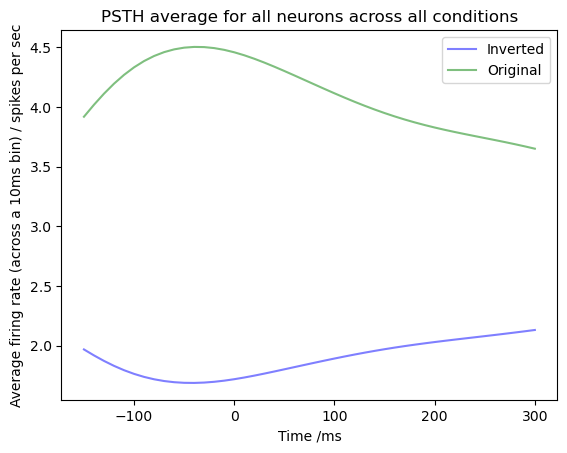

In [ ]:
print(InvertedMovX.shape)
print(MovX.shape)

InvertedMovXmean_c = np.mean(InvertedMovX,dtype=np.float64, axis=1)
InvertedMovXmean_c_i = np.mean(InvertedMovXmean_c, dtype=np.float64, axis=0)
print(InvertedMovXmean_c_i.shape)

MovXmean_c = np.mean(MovX, dtype=np.float64, axis=1)
MovXmean_c_i = np.mean(MovXmean_c, dtype=np.float64, axis=0)
#print(MovXmean_c_i.shape)
plt.plot(np.arange(-150,301,10), InvertedMovXmean_c_i, color = 'b', alpha = 0.5, label= 'Inverted')
plt.plot(np.arange(-150,301,10), MovXmean_c_i, color = 'g', alpha = 0.5, label = 'Original')
plt.legend()
plt.title(f'PSTH average for all neurons across all conditions')  # Average firing rate of 5 neurons over all experimental time.
plt.xlabel("Time /ms")
plt.ylabel("Average firing rate (across a 10ms bin) / spikes per sec")
plt.show()


EXERCISE 2

In [54]:
# NORMALISING
for i in range(182):
    c_t_mat = InvertedMovX[i,:,:]
    c_t_flat = np.ndarray.flatten(c_t_mat)  # make it 1D
    maximum = max(c_t_flat)  # find max value accross time and conditions
    minimum = min(c_t_flat)
    #print(maximum, minimum)
    InvertedMovX[i,:,:] = (InvertedMovX[i,:,:] - minimum)/ (maximum - minimum + 5) # normalising


# MEAN CENTERING
# Calculate the mean across conditions for each neuron and time bin
mean_c = np.mean(InvertedMovX, axis=1, dtype=np.float64)  # Shape (N, T); # taking average across all conditions, c
# Reshape mean for broadcasting
mean_c_expanded = np.expand_dims(mean_c, axis=1)  # Shape (N, 1, T)  # expanded it along the condition axis 
# i.e., you don't need to take the mean again across all neurons, i, but need to find a 2D array of mean values
# Mean-center the data
meancentredInvertedMovX = InvertedMovX - mean_c_expanded


In [56]:
def createVmZ(X, M, N, C, T):
    Xreshaped = np.reshape(X, newshape=(N, C*T))
    print(Xreshaped.shape)

    sample_cov_mat = (1 / (C * T)) * (Xreshaped @ Xreshaped.T)
    print(sample_cov_mat.shape)

    eigvals, eigvects = np.linalg.eigh(sample_cov_mat)  # Use eigh for symmetric matrices
    print(eigvects.shape)

    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]  # sort and reverse list
    eigvals = eigvals[sorted_indices]
    eigvects = eigvects[:, sorted_indices]

    V_m = eigvects[:,:M]  # V_M now has shape (N, M)
    print('Vm', V_m.shape)
    # Projecting the data onto the selected eigenvectors (principal components)
    Z = V_m.T @ Xreshaped  # Shape of Z is (M, C*T)
    print('Z', Z.shape)
    Zreshaped = np.reshape(Z, newshape=(M, C, T))

    return V_m, Zreshaped

In [57]:
# Z MUST BE 3D i.e., HAVE SHAPE LIKE (12, 108, 46)

def createA(Z, M, C, T):
    
    K = int(M*(M-1)*0.5)
    H = np.zeros((K, M, M))

    a = 0 # a = beta index; also the index for row of the KxMxM matrix
    for i in range(M):  # a = row, i = column, j = into the page
        for j in range(i+1, M):  # Upper triangular indices
            H[a,i,j] = 1
            H[a,j,i] = -1
            a += 1

    print(Z.shape)  # (12, 108, 46)

    deltaZ = np.zeros((M, C, T-1))  # One less time bin
    for t in range(T-1):   # Compute time differences
        deltaZ[:,:,t] = Z[:,:,t+1] - Z[:,:,t]
    print(deltaZ.shape)  # (12, 108, 45)
    deltaZ = np.reshape(deltaZ, newshape=(M, C*(T-1)))  # Reshape to (M, T-1)
    print('deltaZ', deltaZ.shape)  # (12, 4860)

    deltaZ_flat = deltaZ.flatten()
    print('deltaZflat', deltaZ_flat.shape)

    print('Z', Z.shape)  # (12, 108, 46)
    #Zreshaped = np.reshape(Z[:,108*45], newshape=(M, 108 * 45)) # Reshape to trials and time steps
    Zsliced = Z[:,:,:(T-1)]
    print("Zsliced", Zsliced.shape)  # (12, 108, 45)

    # Compute W = H * Z
    W = np.tensordot(H, Zsliced, axes=1)
    print("W", W.shape)

    W_flat = W.reshape(K, M * C*(T-1))
    print(W_flat.shape)

    b = W_flat @ deltaZ_flat
    print(b.shape)  # should be a K-dimensional vector
    Q = W_flat @ W_flat.T
    print(Q.shape)  # should be K x K

    beta = np.linalg.solve(Q,b)
    print(beta.shape)

    A = np.tensordot(beta, H, axes=1)

    return A


In [58]:
def createP_FR(A, Z, idx, M):
    eigvals, eigvects = np.linalg.eig(A)
    IMAGeigvals = np.imag(eigvals)
    sorted_indices = np.argsort(IMAGeigvals)[::-1]  # sort and reverse list
    # firsteigval = IMAGeigvals[sorted_indices][idx]
    firsteigvect = eigvects[:, sorted_indices][idx]

    # don't know if I need to normalise each row in the matrix or everything in the matrix...
    realfirsteigvect = np.real(firsteigvect)
    normrealfirsteigvect = realfirsteigvect/(np.linalg.norm(realfirsteigvect))

    imagfirsteigvect = np.imag(firsteigvect)
    normimagfirsteigvect = imagfirsteigvect / (np.linalg.norm(imagfirsteigvect))

    P_FR = np.zeros((2, M))
    print('P_FR', P_FR.shape)
    P_FR[0] = normrealfirsteigvect.T
    P_FR[1] = normimagfirsteigvect.T

    proj = np.tensordot(P_FR, Z, axes=1)
    print('proj', proj.shape)

    return proj, P_FR

In [ ]:
M = 12
C = 108
T = 46
idx = 0

Vm, Z = createVmZ(X=meancentredInvertedMovX, M=M, N=182, C=C, T=T)
A = createA(Z, M=M, C=C, T=T)
proj, P_FR = createP_FR(A, Z, idx, M)

(182, 4968)
(182, 182)
(182, 182)
Vm (182, 12)
Z (12, 4968)
(12, 108, 46)
(12, 108, 45)
deltaZ (12, 4860)
deltaZflat (58320,)
Z (12, 108, 46)
Zsliced (12, 108, 45)
W (66, 12, 108, 45)
(66, 58320)
(66,)
(66, 66)
(66,)
P_FR (2, 12)
proj (2, 108, 46)


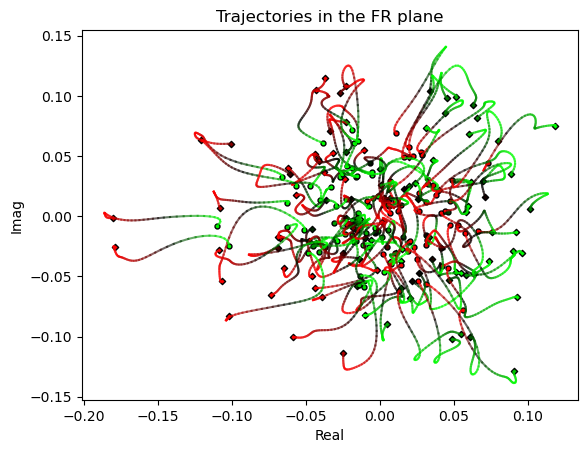

In [62]:
for c in range(108):
     # just randonmly pick the 5th condition - we have assumed that the autonomous dynamics is the same in all conditions 
     # plt.plot(Z_PC1_PC2reshaped[0,c,:], Z_PC1_PC2reshaped[1,c,:])
    xs, ys = proj[0,c,:], proj[1,c,:]
    colours = get_colors(xs, ys, alt_colors=False)# Get the color mapping
    #print(len(colours))
    #plt.plot(xs, ys, color = colours[c%46], alpha=0.6)
    #cond_color.plot_start(xs[:,0], ys[:,0], colours, markersize=5)
 
    for i in range(len(xs) - 1):  # Loop over consecutive points
        plt.plot(xs[i:i+2], ys[i:i+2], color=colours[i], alpha=0.6)
    # Mark the start of the trajectory
    cond_color.plot_start(xs[0], ys[0], colours[0], markersize=50)
    # Mark the end of the trajectory
    cond_color.plot_end(xs[-1], ys[-1], colours[-1], markersize=10)

# plot_start(xs, ys, colours, markersize=5, ax=None)
# plot_end(xs, ys, colours, markersize=5, ax=None)
# plt.title(f'PSTH for condition {c}')  # Average firing rate of 5 neurons over all experimental time.
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('Trajectories in the FR plane')
plt.show()